In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import sys
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = 18

In [3]:
# Add model path to sys.path
path_to_model_directory = os.path.abspath("../model")
if path_to_model_directory not in sys.path:
    sys.path.append(path_to_model_directory)

# Now you can import your class
from PreTrainer import PreTrainer
from DownstreamTask import DownstreamClassificationTaskTrainer
from data import validate_data_format, ServeDataset, HitDataset
from TennisShotEmbedder import TennisShotEmbedder
from model_builder import build_tennis_embedder

In [4]:
# Configure the PreTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50
train_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/train'
val_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/val'
test_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/test'
model_config_file = '/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/model/configs/default.yaml'
model_weights_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/trained_models/best_model.pth"

## Check Serve and Hit Dataset

In [38]:
train_serve_dataset = ServeDataset(labels_path = train_path)

In [39]:
val_serve_dataset = ServeDataset(labels_path = val_path)

In [40]:
test_serve_dataset = ServeDataset(labels_path = test_path)

In [41]:
train_hit_dataset = HitDataset(labels_path = train_path)

In [42]:
val_hit_dataset = HitDataset(labels_path = val_path)

In [43]:
test_hit_dataset = HitDataset(labels_path = test_path)

Train Serve Dataset:
Pose3d Shape:  (81, 17, 3)
Position2d Shape:  (81, 2)
Number of PoseGraphs:  81
Number of Samples:  498
Number of Unique Labels:  2
Unique Labels and their counts:
Label Fault: 13
Label In: 485


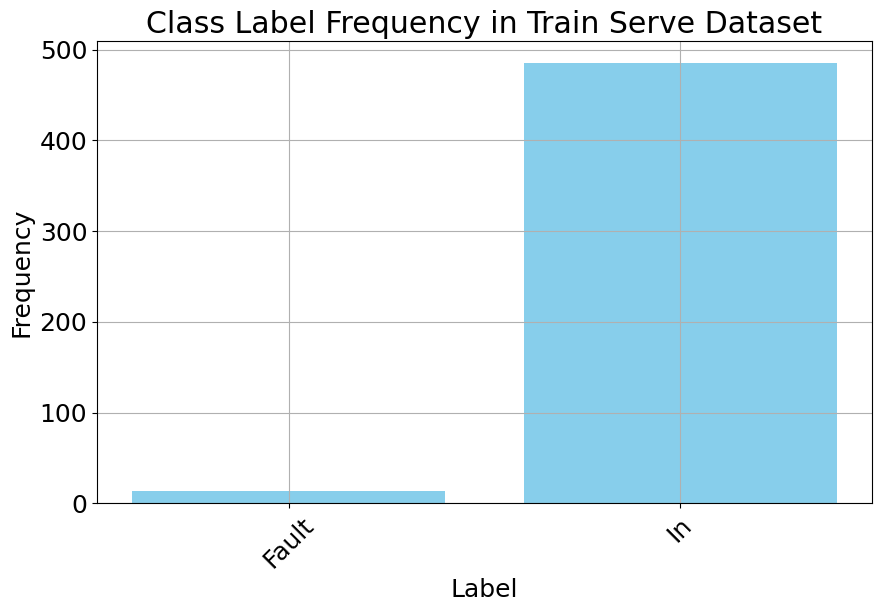

In [44]:
def get_label_dict(task, keep_labels = None):
        
        if task == 'hit':
            label_dict = {
                0: 'Backhand_Flat',
                1: 'Backhand_Slice',
                2: 'Backhand_Topspin',
                3: 'Backhand_Unsure',
                4: 'Backhand_Volley',
                5: 'Forehand_Flat',
                6: 'Forehand_Slice',
                7: 'Forehand_Smash',
                8: 'Forehand_Topspin',
                9: 'Forehand_Unsure',
                10: 'Forehand_Volley'
            }

            if keep_labels: 
                filtered_label_dict = {}
                count = 0
                for key, value in label_dict.items():
                    if value in keep_labels:
                        filtered_label_dict[count] = value
                        count += 1
                label_dict = filtered_label_dict
            return label_dict
            
        elif task == 'serve':
            return {
                0: 'Fault', 
                1: 'In'
            } 
        
def get_data_info(dataset, dataset_name, task="serve", keep_labels = None):
    pose3d_list = []
    position2d_list = []
    poseGraph_list = []
    label_list = []
    if keep_labels:
        label_dict = get_label_dict(task, keep_labels)
    else:
        label_dict = get_label_dict(task)


    print(f"{dataset_name}:")

    counter = 0
    for pose3d, position2d, poseGraph, label in dataset:
        if counter == 0:
            print("Pose3d Shape: ", pose3d.shape)
            print("Position2d Shape: ", position2d.shape)
            print("Number of PoseGraphs: ", len(poseGraph))
            counter += 1
        pose3d_list.append(pose3d)
        position2d_list.append(position2d)
        poseGraph_list.append(poseGraph)
        label_list.append(label)
    
    if len(pose3d_list) == len(position2d_list) == len(poseGraph_list) == len(label_list):
        print("Number of Samples: ", len(pose3d_list))
    else:
        print("Number of Samples Do Not Match")

    # Translate numeric labels to text labels for counting
    text_labels = [label_dict[label] for label in label_list]
    labels, counts = np.unique(text_labels, return_counts=True)

    print("Number of Unique Labels: ", len(labels))
    print("Unique Labels and their counts:")
    for label, count in zip(labels, counts):
        print(f"Label {label}: {count}")

    # Plotting the histogram of label frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(labels)), counts, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title(f'Class Label Frequency in {dataset_name}')
    plt.xticks(range(len(labels)), labels, rotation=45)  # Set labels on the x-axis
    plt.grid(True)
    plt.show()



get_data_info(train_serve_dataset, "Train Serve Dataset", task="serve")

Val Serve Dataset:
Pose3d Shape:  (83, 17, 3)
Position2d Shape:  (83, 2)
Number of PoseGraphs:  83
Number of Samples:  132
Number of Unique Labels:  2
Unique Labels and their counts:
Label Fault: 3
Label In: 129


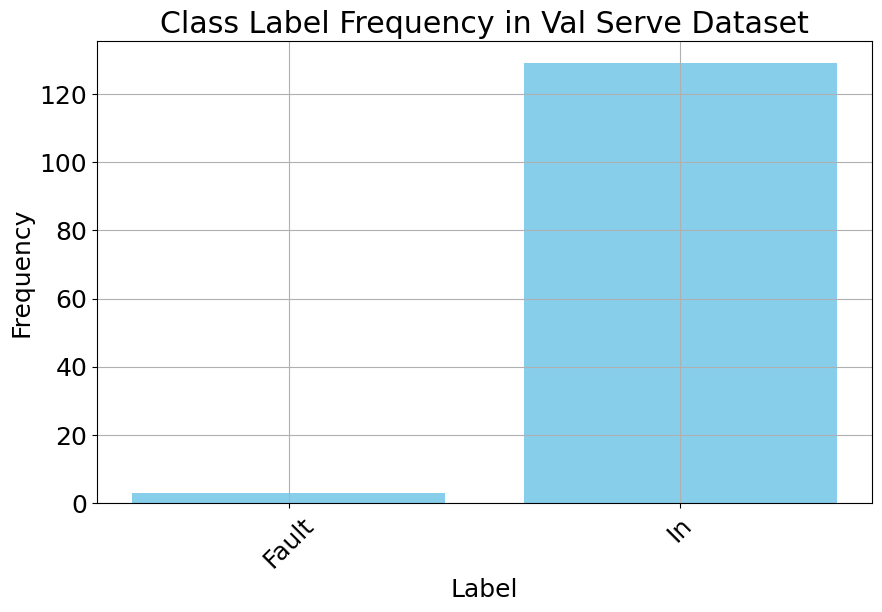

In [45]:
get_data_info(val_serve_dataset, "Val Serve Dataset", task="serve")

Test Serve Dataset:
Pose3d Shape:  (77, 17, 3)
Position2d Shape:  (77, 2)
Number of PoseGraphs:  77
Number of Samples:  90
Number of Unique Labels:  2
Unique Labels and their counts:
Label Fault: 2
Label In: 88


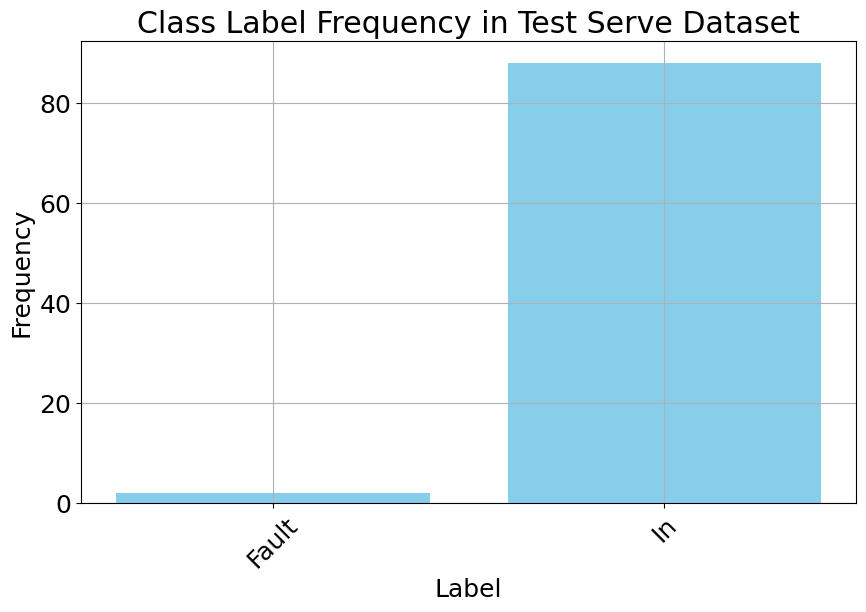

In [46]:
get_data_info(test_serve_dataset, "Test Serve Dataset", task="serve")

Train Hit Dataset:
Pose3d Shape:  (20, 17, 3)
Position2d Shape:  (20, 2)
Number of PoseGraphs:  20
Number of Samples:  1717
Number of Unique Labels:  11
Unique Labels and their counts:
Label Backhand_Flat: 11
Label Backhand_Slice: 269
Label Backhand_Topspin: 555
Label Backhand_Unsure: 28
Label Backhand_Volley: 22
Label Forehand_Flat: 15
Label Forehand_Slice: 56
Label Forehand_Smash: 14
Label Forehand_Topspin: 690
Label Forehand_Unsure: 40
Label Forehand_Volley: 17


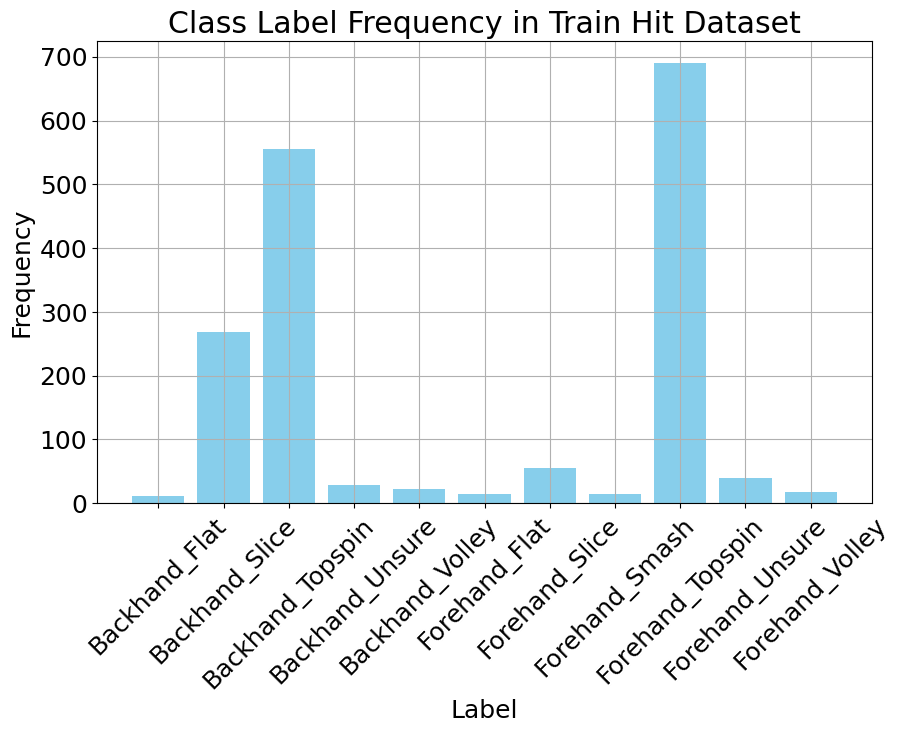

In [47]:
get_data_info(train_hit_dataset, "Train Hit Dataset", task="hit")

Val Hit Dataset:
Pose3d Shape:  (19, 17, 3)
Position2d Shape:  (19, 2)
Number of PoseGraphs:  19
Number of Samples:  427
Number of Unique Labels:  11
Unique Labels and their counts:
Label Backhand_Flat: 8
Label Backhand_Slice: 64
Label Backhand_Topspin: 130
Label Backhand_Unsure: 7
Label Backhand_Volley: 13
Label Forehand_Flat: 5
Label Forehand_Slice: 10
Label Forehand_Smash: 2
Label Forehand_Topspin: 170
Label Forehand_Unsure: 10
Label Forehand_Volley: 8


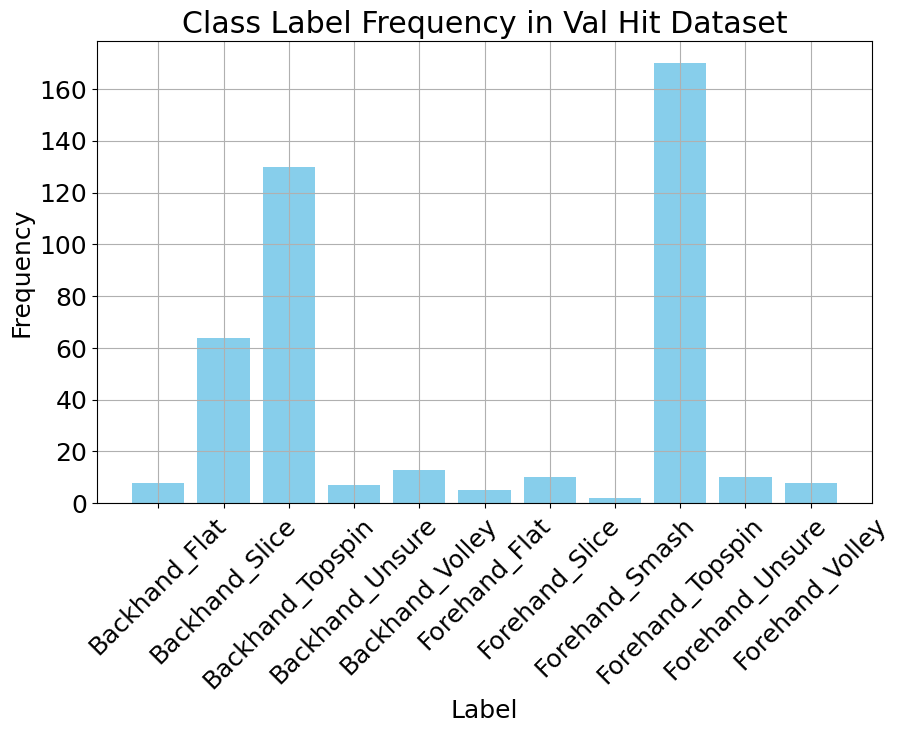

In [48]:
get_data_info(val_hit_dataset, "Val Hit Dataset", task = "hit")

Test Hit Dataset:
Pose3d Shape:  (24, 17, 3)
Position2d Shape:  (24, 2)
Number of PoseGraphs:  24
Number of Samples:  277
Number of Unique Labels:  11
Unique Labels and their counts:
Label Backhand_Flat: 2
Label Backhand_Slice: 14
Label Backhand_Topspin: 117
Label Backhand_Unsure: 3
Label Backhand_Volley: 1
Label Forehand_Flat: 2
Label Forehand_Slice: 5
Label Forehand_Smash: 1
Label Forehand_Topspin: 127
Label Forehand_Unsure: 4
Label Forehand_Volley: 1


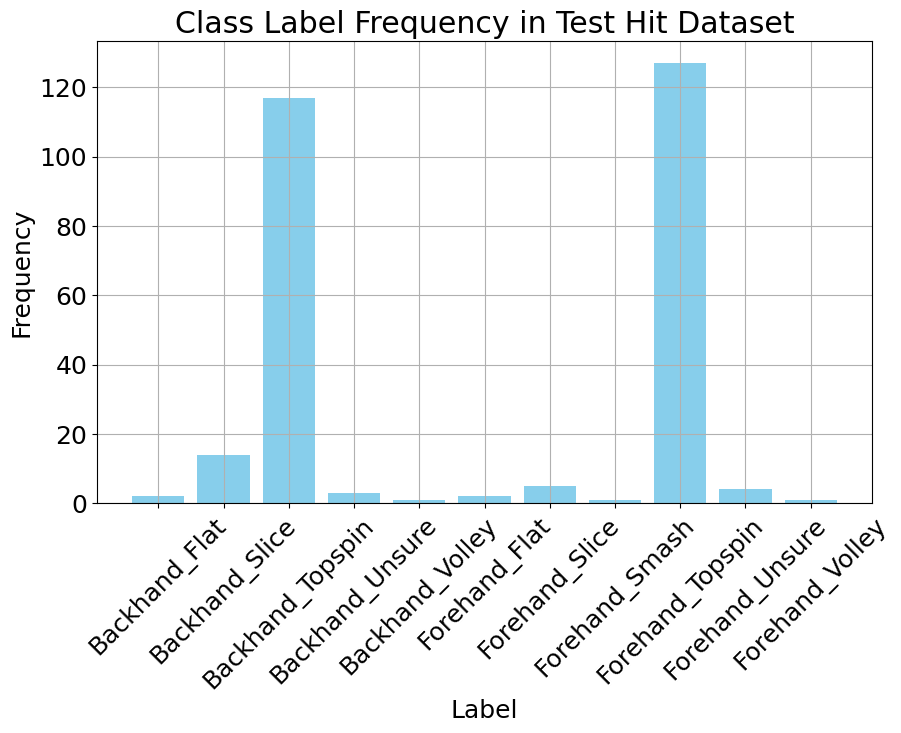

In [49]:
get_data_info(test_hit_dataset, "Test Hit Dataset", task = "hit")

## Train for Serve and Hit Classification Downstream Task [Train Complete Model - No Freezing]

#### Train and Evaluate for Serve Classification

In [17]:
# Configure the DownstreamClassifierTaskTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20

In [18]:
serve_downstream_model = DownstreamClassificationTaskTrainer(model_config_path=model_config_file,
                                                             model_weights_path=model_weights_path, 
                                                             train_path=train_path, 
                                                             val_path=val_path, 
                                                             test_path=test_path, 
                                                             model_save_path='downstream_trained_models', 
                                                             batch_size=BATCH_SIZE, 
                                                             lr=LR, 
                                                             epochs=EPOCHS, 
                                                             task = 'serve')

Using device: cuda


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 1, Loss: 0.47135134041309357
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.18369259238243102


100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


Epoch 2, Loss: 0.1348041894088965
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.10597187969833613


100%|██████████| 16/16 [00:04<00:00,  3.97it/s]


Epoch 3, Loss: 0.1349786159407813
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.09423402175307274


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Epoch 4, Loss: 0.11893573740962893
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.09418503120541573


100%|██████████| 16/16 [00:04<00:00,  3.85it/s]


Epoch 5, Loss: 0.11984737182501704
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.09322632290422916


100%|██████████| 16/16 [00:04<00:00,  3.94it/s]


Epoch 6, Loss: 0.12535376683808863
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.09287264384329319


100%|██████████| 16/16 [00:04<00:00,  3.83it/s]


Epoch 7, Loss: 0.1231939970748499
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


Epoch 8, Loss: 0.11946031427942216
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


Epoch 9, Loss: 0.12074217468034476
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Epoch 10, Loss: 0.12323461566120386
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.83it/s]


Epoch 11, Loss: 0.1179778395453468
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.84it/s]


Epoch 12, Loss: 0.1188014317303896
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.94it/s]


Epoch 13, Loss: 0.11800227116327733
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Saving model at serve_downstream_trained_models with validation loss of 0.09174824357032776


100%|██████████| 16/16 [00:04<00:00,  3.87it/s]


Epoch 14, Loss: 0.11798981809988618
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.89it/s]


Epoch 15, Loss: 0.1254413656424731
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.92it/s]


Epoch 16, Loss: 0.12241238669957966
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.90it/s]


Epoch 17, Loss: 0.12226396182086319
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Epoch 18, Loss: 0.11978501337580383
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  4.00it/s]


Epoch 19, Loss: 0.11979765084106475
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543


100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


Epoch 20, Loss: 0.11759696330409497
Validation Accuracy: 0.9770992366412213, Validation Precision: 0.9547229182448574, Validation Recall: 0.9770992366412213, Validation F1 Score: 0.9657814848654543
Test Accuracy: 0.9777777777777777, Test Precision: 0.9560493827160493, Test Recall: 0.9777777777777777, Test F1 Score: 0.9667915106117353


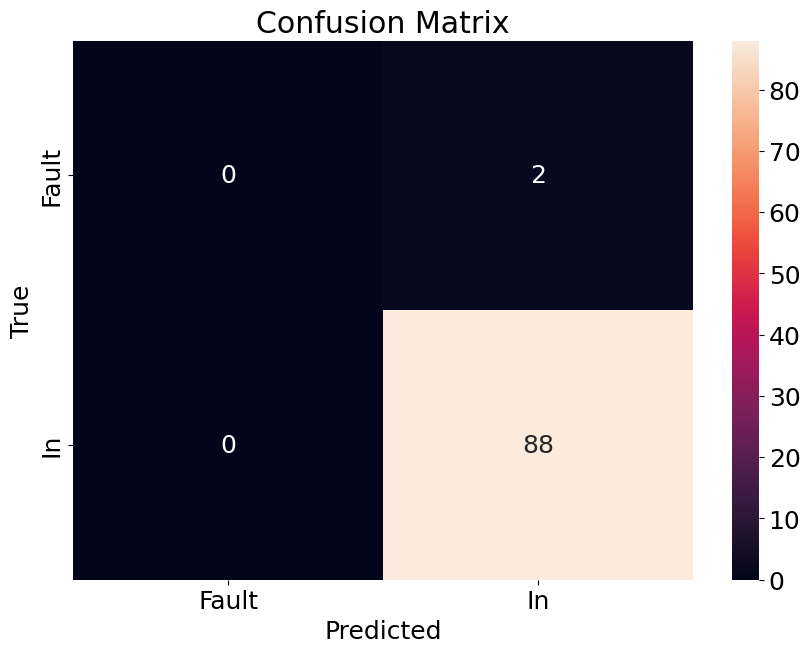

In [19]:
train_loss_history = serve_downstream_model.train()

In [ ]:
serve_model_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/serve_downstream_trained_models/best_model.pth"
serve_downstream_model.load_model(serve_model_path)

Test Accuracy: 0.9777777777777777, Test Precision: 0.9560493827160493, Test Recall: 0.9777777777777777, Test F1 Score: 0.9667915106117353


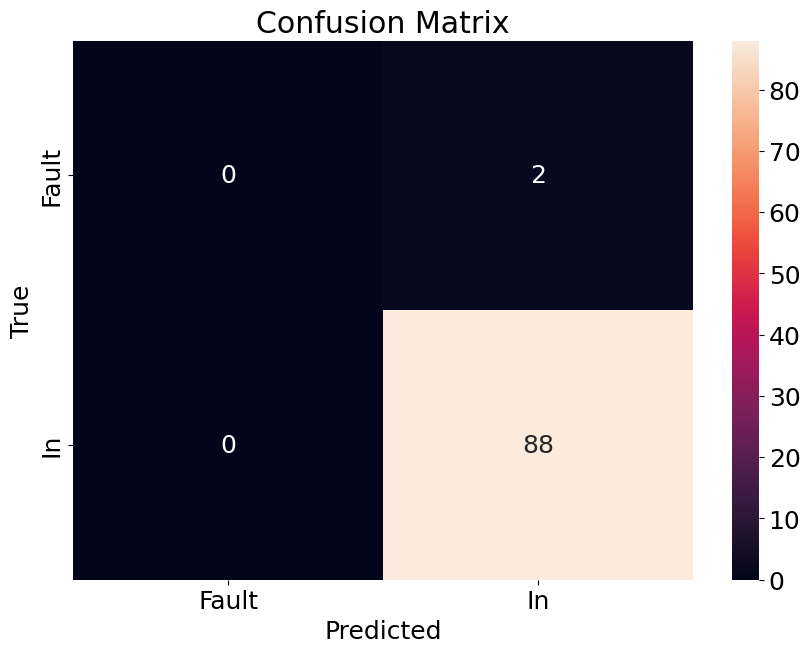

In [53]:
serve_downstream_model.test_trained_model(test_path, save_path = False)

#### Train and Evaluate for Hit Classification

In [55]:
# Configure the DownstreamClassifierTaskTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50

In [56]:
hit_downstream_model = DownstreamClassificationTaskTrainer(model_config_path=model_config_file,
                                                             model_weights_path=model_weights_path, 
                                                             train_path=train_path, 
                                                             val_path=val_path, 
                                                             test_path=test_path, 
                                                             model_save_path='downstream_trained_models', 
                                                             batch_size=BATCH_SIZE, 
                                                             lr=LR, 
                                                             epochs=EPOCHS, 
                                                             task = 'hit')

Using device: cuda


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:11<00:00,  4.75it/s]


Epoch 1, Loss: 1.5771657383000408
Validation Accuracy: 0.3981264637002342, Validation Precision: 0.1585046810984539, Validation Recall: 0.3981264637002342, Validation F1 Score: 0.22673868954452198
Saving model at hit_downstream_trained_models with validation loss of 1.544764565570014


100%|██████████| 54/54 [00:11<00:00,  4.89it/s]


Epoch 2, Loss: 1.45607179624063
Validation Accuracy: 0.4613583138173302, Validation Precision: 0.3676522745282967, Validation Recall: 0.4613583138173302, Validation F1 Score: 0.38683772336508426
Saving model at hit_downstream_trained_models with validation loss of 1.4861971054758345


100%|██████████| 54/54 [00:11<00:00,  4.85it/s]


Epoch 3, Loss: 1.3975992776729442
Validation Accuracy: 0.5058548009367682, Validation Precision: 0.4370509532102038, Validation Recall: 0.5058548009367682, Validation F1 Score: 0.4447572143262249
Saving model at hit_downstream_trained_models with validation loss of 1.4121404205049788


100%|██████████| 54/54 [00:11<00:00,  4.72it/s]


Epoch 4, Loss: 1.3373541843008112
Validation Accuracy: 0.5199063231850117, Validation Precision: 0.4033230512909475, Validation Recall: 0.5199063231850117, Validation F1 Score: 0.43801065243169474


100%|██████████| 54/54 [00:11<00:00,  4.71it/s]


Epoch 5, Loss: 1.3161160073898457
Validation Accuracy: 0.5128805620608899, Validation Precision: 0.4586739076504122, Validation Recall: 0.5128805620608899, Validation F1 Score: 0.4509189607089066
Saving model at hit_downstream_trained_models with validation loss of 1.3403159976005554


100%|██████████| 54/54 [00:11<00:00,  4.69it/s]


Epoch 6, Loss: 1.2772732973098755
Validation Accuracy: 0.522248243559719, Validation Precision: 0.4239692565219497, Validation Recall: 0.522248243559719, Validation F1 Score: 0.45248487810773236
Saving model at hit_downstream_trained_models with validation loss of 1.3362421435969216


100%|██████████| 54/54 [00:10<00:00,  4.91it/s]


Epoch 7, Loss: 1.2317087550957997
Validation Accuracy: 0.5199063231850117, Validation Precision: 0.48510189714462054, Validation Recall: 0.5199063231850117, Validation F1 Score: 0.45980953779985934


100%|██████████| 54/54 [00:11<00:00,  4.76it/s]


Epoch 8, Loss: 1.259257498714659
Validation Accuracy: 0.4964871194379391, Validation Precision: 0.39577378601055274, Validation Recall: 0.4964871194379391, Validation F1 Score: 0.4124607491115392


100%|██████████| 54/54 [00:10<00:00,  4.93it/s]


Epoch 9, Loss: 1.2103999025291867
Validation Accuracy: 0.5901639344262295, Validation Precision: 0.5094108955057434, Validation Recall: 0.5901639344262295, Validation F1 Score: 0.5345755206649112
Saving model at hit_downstream_trained_models with validation loss of 1.209425538778305


100%|██████████| 54/54 [00:11<00:00,  4.70it/s]


Epoch 10, Loss: 1.1708896712020591
Validation Accuracy: 0.5831381733021077, Validation Precision: 0.5164347887797638, Validation Recall: 0.5831381733021077, Validation F1 Score: 0.5262355003598709


100%|██████████| 54/54 [00:11<00:00,  4.76it/s]


Epoch 11, Loss: 1.1595065582681585
Validation Accuracy: 0.5714285714285714, Validation Precision: 0.5133116111733359, Validation Recall: 0.5714285714285714, Validation F1 Score: 0.5196895821039073


100%|██████████| 54/54 [00:11<00:00,  4.80it/s]


Epoch 12, Loss: 1.1217472928541679
Validation Accuracy: 0.585480093676815, Validation Precision: 0.5343096916591114, Validation Recall: 0.585480093676815, Validation F1 Score: 0.5176080968353971


100%|██████████| 54/54 [00:11<00:00,  4.59it/s]


Epoch 13, Loss: 1.1192235979768965
Validation Accuracy: 0.5831381733021077, Validation Precision: 0.5216357429486675, Validation Recall: 0.5831381733021077, Validation F1 Score: 0.5426224404496289
Saving model at hit_downstream_trained_models with validation loss of 1.169493943452835


100%|██████████| 54/54 [00:11<00:00,  4.79it/s]


Epoch 14, Loss: 1.08491693271531
Validation Accuracy: 0.5807962529274004, Validation Precision: 0.5361860281258615, Validation Recall: 0.5807962529274004, Validation F1 Score: 0.5418117515731274


100%|██████████| 54/54 [00:11<00:00,  4.82it/s]


Epoch 15, Loss: 1.0586218039194744
Validation Accuracy: 0.5995316159250585, Validation Precision: 0.5494210033862705, Validation Recall: 0.5995316159250585, Validation F1 Score: 0.5575118343335852
Saving model at hit_downstream_trained_models with validation loss of 1.1418091186455317


100%|██████████| 54/54 [00:11<00:00,  4.87it/s]


Epoch 16, Loss: 1.0420764441843386
Validation Accuracy: 0.5925058548009368, Validation Precision: 0.5505284785140044, Validation Recall: 0.5925058548009368, Validation F1 Score: 0.5578590776024847


100%|██████████| 54/54 [00:11<00:00,  4.79it/s]


Epoch 17, Loss: 1.04873115045053
Validation Accuracy: 0.585480093676815, Validation Precision: 0.5614850772060334, Validation Recall: 0.585480093676815, Validation F1 Score: 0.5493254306553539


100%|██████████| 54/54 [00:10<00:00,  4.95it/s]


Epoch 18, Loss: 1.0055570503075917
Validation Accuracy: 0.594847775175644, Validation Precision: 0.5702329086871395, Validation Recall: 0.594847775175644, Validation F1 Score: 0.5631425161694513


100%|██████████| 54/54 [00:11<00:00,  4.78it/s]


Epoch 19, Loss: 0.987906547608199
Validation Accuracy: 0.5925058548009368, Validation Precision: 0.5467478351553293, Validation Recall: 0.5925058548009368, Validation F1 Score: 0.5436621494408047


100%|██████████| 54/54 [00:11<00:00,  4.85it/s]


Epoch 20, Loss: 1.0448434275609475
Validation Accuracy: 0.5878220140515222, Validation Precision: 0.5187611824505007, Validation Recall: 0.5878220140515222, Validation F1 Score: 0.5434143006429976


100%|██████████| 54/54 [00:11<00:00,  4.81it/s]


Epoch 21, Loss: 0.9864890972773234
Validation Accuracy: 0.594847775175644, Validation Precision: 0.5514722375686101, Validation Recall: 0.594847775175644, Validation F1 Score: 0.5580480752658739
Saving model at hit_downstream_trained_models with validation loss of 1.1181467941829137


100%|██████████| 54/54 [00:11<00:00,  4.53it/s]


Epoch 22, Loss: 0.9597416233133387
Validation Accuracy: 0.6018735362997658, Validation Precision: 0.5538225525441648, Validation Recall: 0.6018735362997658, Validation F1 Score: 0.5568602842080003


100%|██████████| 54/54 [00:11<00:00,  4.69it/s]


Epoch 23, Loss: 0.978538101470029
Validation Accuracy: 0.5925058548009368, Validation Precision: 0.5532952082555864, Validation Recall: 0.5925058548009368, Validation F1 Score: 0.5541152558412806


100%|██████████| 54/54 [00:11<00:00,  4.77it/s]


Epoch 24, Loss: 0.957603739367591
Validation Accuracy: 0.6018735362997658, Validation Precision: 0.5700418145869076, Validation Recall: 0.6018735362997658, Validation F1 Score: 0.5749073088247503


100%|██████████| 54/54 [00:11<00:00,  4.72it/s]


Epoch 25, Loss: 0.9448903401692709
Validation Accuracy: 0.5995316159250585, Validation Precision: 0.5824434763213909, Validation Recall: 0.5995316159250585, Validation F1 Score: 0.5447587721836028


100%|██████████| 54/54 [00:10<00:00,  4.93it/s]


Epoch 26, Loss: 0.9013819606215866
Validation Accuracy: 0.5995316159250585, Validation Precision: 0.5625638060048005, Validation Recall: 0.5995316159250585, Validation F1 Score: 0.565962014273439


100%|██████████| 54/54 [00:11<00:00,  4.66it/s]


Epoch 27, Loss: 0.9223225044983404
Validation Accuracy: 0.6065573770491803, Validation Precision: 0.571717360238063, Validation Recall: 0.6065573770491803, Validation F1 Score: 0.5761023073892261


100%|██████████| 54/54 [00:10<00:00,  4.97it/s]


Epoch 28, Loss: 0.9070540644504406
Validation Accuracy: 0.5878220140515222, Validation Precision: 0.5681470171730602, Validation Recall: 0.5878220140515222, Validation F1 Score: 0.5664651679890927


100%|██████████| 54/54 [00:11<00:00,  4.80it/s]


Epoch 29, Loss: 0.9054895727722733
Validation Accuracy: 0.5807962529274004, Validation Precision: 0.544830068927197, Validation Recall: 0.5807962529274004, Validation F1 Score: 0.551119378091124


100%|██████████| 54/54 [00:11<00:00,  4.77it/s]


Epoch 30, Loss: 0.8764041154472916
Validation Accuracy: 0.5620608899297423, Validation Precision: 0.5534507806239909, Validation Recall: 0.5620608899297423, Validation F1 Score: 0.541891242752481


100%|██████████| 54/54 [00:11<00:00,  4.75it/s]


Epoch 31, Loss: 0.8575688534312778
Validation Accuracy: 0.6018735362997658, Validation Precision: 0.5415399117842669, Validation Recall: 0.6018735362997658, Validation F1 Score: 0.5673304535214903


100%|██████████| 54/54 [00:10<00:00,  4.96it/s]


Epoch 32, Loss: 0.8676318371737445
Validation Accuracy: 0.5925058548009368, Validation Precision: 0.5608660903182846, Validation Recall: 0.5925058548009368, Validation F1 Score: 0.5746799991956388


100%|██████████| 54/54 [00:11<00:00,  4.65it/s]


Epoch 33, Loss: 0.8479901303847631
Validation Accuracy: 0.6182669789227166, Validation Precision: 0.5909434414600416, Validation Recall: 0.6182669789227166, Validation F1 Score: 0.566360130238316


100%|██████████| 54/54 [00:10<00:00,  4.98it/s]


Epoch 34, Loss: 0.8195835445766095
Validation Accuracy: 0.6206088992974239, Validation Precision: 0.5741318899555914, Validation Recall: 0.6206088992974239, Validation F1 Score: 0.5954039385014087


100%|██████████| 54/54 [00:11<00:00,  4.88it/s]


Epoch 35, Loss: 0.7958070503340827
Validation Accuracy: 0.6088992974238876, Validation Precision: 0.5533628767642447, Validation Recall: 0.6088992974238876, Validation F1 Score: 0.5729747349738639


100%|██████████| 54/54 [00:10<00:00,  4.96it/s]


Epoch 36, Loss: 0.788446694612503
Validation Accuracy: 0.5995316159250585, Validation Precision: 0.5609320739351783, Validation Recall: 0.5995316159250585, Validation F1 Score: 0.5674812147126971


100%|██████████| 54/54 [00:11<00:00,  4.68it/s]


Epoch 37, Loss: 0.7872074202254966
Validation Accuracy: 0.6159250585480094, Validation Precision: 0.577287045813217, Validation Recall: 0.6159250585480094, Validation F1 Score: 0.5715567860770433


100%|██████████| 54/54 [00:11<00:00,  4.75it/s]


Epoch 38, Loss: 0.8068738767394313
Validation Accuracy: 0.6018735362997658, Validation Precision: 0.5704026958173191, Validation Recall: 0.6018735362997658, Validation F1 Score: 0.5716967580082902


100%|██████████| 54/54 [00:11<00:00,  4.81it/s]


Epoch 39, Loss: 0.7592096913743902
Validation Accuracy: 0.6065573770491803, Validation Precision: 0.5579550459499453, Validation Recall: 0.6065573770491803, Validation F1 Score: 0.56461505953679


100%|██████████| 54/54 [00:11<00:00,  4.66it/s]


Epoch 40, Loss: 0.7693428860770332
Validation Accuracy: 0.6065573770491803, Validation Precision: 0.5659934015284358, Validation Recall: 0.6065573770491803, Validation F1 Score: 0.5805761033928525


100%|██████████| 54/54 [00:10<00:00,  4.95it/s]


Epoch 41, Loss: 0.78551977928038
Validation Accuracy: 0.6088992974238876, Validation Precision: 0.5874312016693042, Validation Recall: 0.6088992974238876, Validation F1 Score: 0.5919122129820185


100%|██████████| 54/54 [00:10<00:00,  4.91it/s]


Epoch 42, Loss: 0.7450528773996565
Validation Accuracy: 0.6088992974238876, Validation Precision: 0.5746976100965451, Validation Recall: 0.6088992974238876, Validation F1 Score: 0.5759529155057163


100%|██████████| 54/54 [00:11<00:00,  4.84it/s]


Epoch 43, Loss: 0.7108703647498731
Validation Accuracy: 0.6182669789227166, Validation Precision: 0.5966340265436954, Validation Recall: 0.6182669789227166, Validation F1 Score: 0.5973014670606971


100%|██████████| 54/54 [00:10<00:00,  4.95it/s]


Epoch 44, Loss: 0.7280625965860155
Validation Accuracy: 0.6042154566744731, Validation Precision: 0.5661499792272128, Validation Recall: 0.6042154566744731, Validation F1 Score: 0.568729234680568


100%|██████████| 54/54 [00:11<00:00,  4.79it/s]


Epoch 45, Loss: 0.7049279312292734
Validation Accuracy: 0.5901639344262295, Validation Precision: 0.5804368153314288, Validation Recall: 0.5901639344262295, Validation F1 Score: 0.5711438930034896


100%|██████████| 54/54 [00:11<00:00,  4.87it/s]


Epoch 46, Loss: 0.6761270270303443
Validation Accuracy: 0.6159250585480094, Validation Precision: 0.6028121076587991, Validation Recall: 0.6159250585480094, Validation F1 Score: 0.5868524271359108


100%|██████████| 54/54 [00:10<00:00,  4.99it/s]


Epoch 47, Loss: 0.6539260568442168
Validation Accuracy: 0.5831381733021077, Validation Precision: 0.5761426414620104, Validation Recall: 0.5831381733021077, Validation F1 Score: 0.5625315118990069


100%|██████████| 54/54 [00:11<00:00,  4.79it/s]


Epoch 48, Loss: 0.6670681773512451
Validation Accuracy: 0.6135831381733021, Validation Precision: 0.601569754696206, Validation Recall: 0.6135831381733021, Validation F1 Score: 0.5943516899908727


100%|██████████| 54/54 [00:11<00:00,  4.61it/s]


Epoch 49, Loss: 0.7084586785899268
Validation Accuracy: 0.5784543325526932, Validation Precision: 0.5729761979065938, Validation Recall: 0.5784543325526932, Validation F1 Score: 0.5579145626589703


100%|██████████| 54/54 [00:10<00:00,  4.92it/s]


Epoch 50, Loss: 0.6199052692563446
Validation Accuracy: 0.6042154566744731, Validation Precision: 0.572409835458593, Validation Recall: 0.6042154566744731, Validation F1 Score: 0.5831756111159693
Test Accuracy: 0.6714801444043321, Test Precision: 0.6595577125054186, Test Recall: 0.6714801444043321, Test F1 Score: 0.6648617584841633


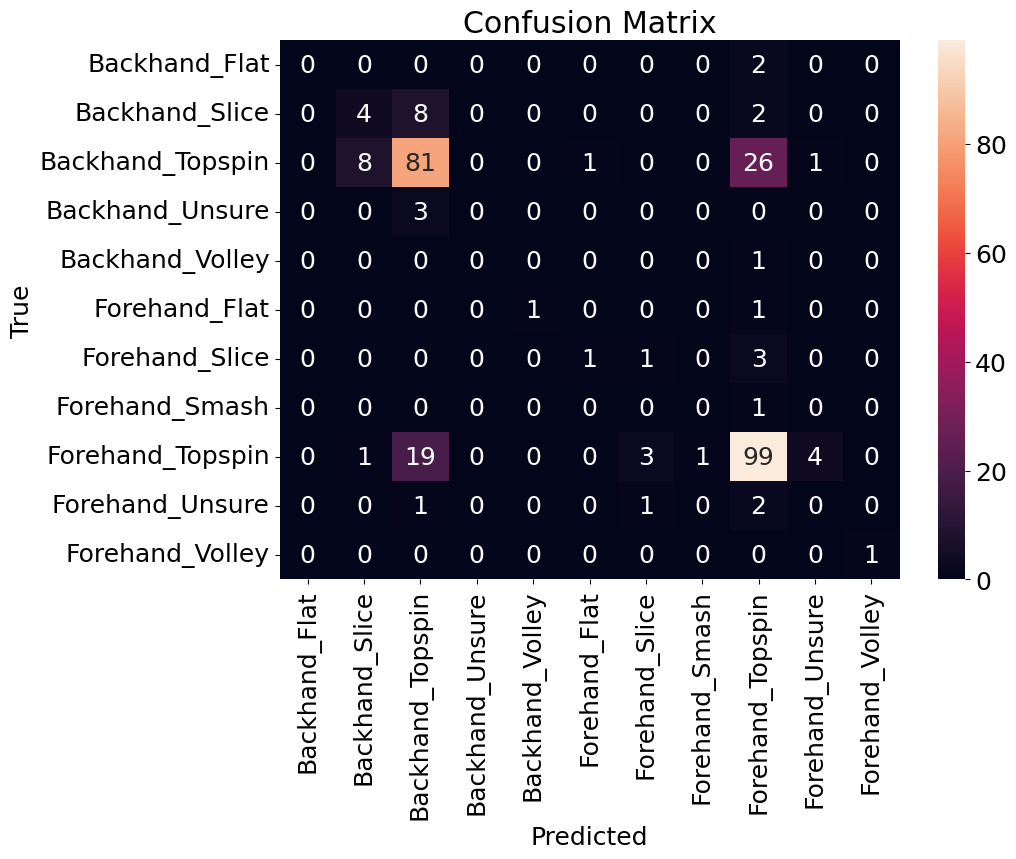

In [57]:
train_loss_history = hit_downstream_model.train()

In [58]:
hit_model_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth"
hit_downstream_model.load_model(hit_model_path)

Model loaded from /home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth


Test Accuracy: 0.6534296028880866, Test Precision: 0.6538916980995935, Test Recall: 0.6534296028880866, Test F1 Score: 0.6360344160947178


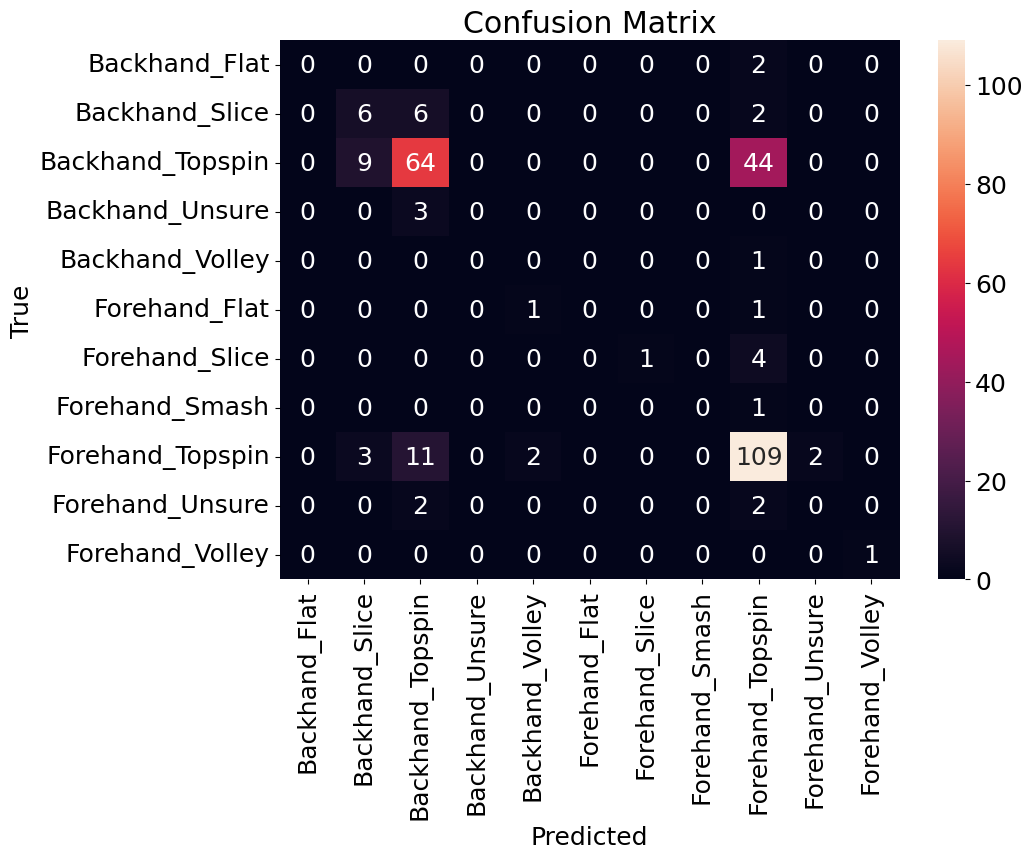

In [59]:
hit_downstream_model.test_trained_model(test_path, save_path = False)

### Add Labels and Keep Top 5 for Hit Dataset

In [60]:
hit_dataset_labels = {'Backhand_Flat': 0, 'Backhand_Slice': 1, 'Backhand_Topspin': 2, 'Backhand_Unsure': 3, 'Backhand_Volley': 4, 'Forehand_Flat': 5, 'Forehand_Slice': 6, 'Forehand_Smash': 7, 'Forehand_Topspin': 8, 'Forehand_Unsure': 9, 'Forehand_Volley': 10}
hit_dataset_labels = {value: key for key, value in hit_dataset_labels.items()}
hit_dataset_labels


{0: 'Backhand_Flat',
 1: 'Backhand_Slice',
 2: 'Backhand_Topspin',
 3: 'Backhand_Unsure',
 4: 'Backhand_Volley',
 5: 'Forehand_Flat',
 6: 'Forehand_Slice',
 7: 'Forehand_Smash',
 8: 'Forehand_Topspin',
 9: 'Forehand_Unsure',
 10: 'Forehand_Volley'}

In [61]:
serve_dataset_labels = {'Fault': 0, 'In': 1}
serve_dataset_labels = {value: key for key, value in serve_dataset_labels.items()}
serve_dataset_labels

{0: 'Fault', 1: 'In'}

In [56]:
train_serve_dataset = ServeDataset(labels_path = train_path)

{'Fault': 0, 'In': 1}


In [62]:
def get_top_n_labels(dataset, label_mapping, n=4):
    # Initialize a dictionary to store label frequencies
    label_counts = {}

    # Iterate through the dataset to count each label
    for _, _, _, label in dataset:
        label_counts[label] = label_counts.get(label, 0) + 1

    # Sort the labels by their frequency in descending order
    sorted_labels = sorted(label_counts.items(), key=lambda item: item[1], reverse=True)

    # Display the top n labels
    print(f"Top {n} most frequent labels:")
    for label, count in sorted_labels[:n]:
        print(f"{label_mapping.get(label, 'Unknown')}: {count}")

    # Display labels that are not in the top n but are still part of the dataset
    if n < len(sorted_labels):
        print("\nLabels to ignore and their frequencies:")
        for label, count in sorted_labels[n:]:
            print(f"{label_mapping.get(label, 'Unknown')}: {count}")
    else:
        print("\nNo labels to ignore.")


get_top_n_labels(train_hit_dataset, hit_dataset_labels, n=4)


Top 4 most frequent labels:
Forehand_Topspin: 690
Backhand_Topspin: 555
Backhand_Slice: 269
Forehand_Slice: 56

Labels to ignore and their frequencies:
Forehand_Unsure: 40
Backhand_Unsure: 28
Backhand_Volley: 22
Forehand_Volley: 17
Forehand_Flat: 15
Forehand_Smash: 14
Backhand_Flat: 11


In [63]:
get_top_n_labels(val_hit_dataset, hit_dataset_labels, n=4)

Top 4 most frequent labels:
Forehand_Topspin: 170
Backhand_Topspin: 130
Backhand_Slice: 64
Backhand_Volley: 13

Labels to ignore and their frequencies:
Forehand_Unsure: 10
Forehand_Slice: 10
Backhand_Flat: 8
Forehand_Volley: 8
Backhand_Unsure: 7
Forehand_Flat: 5
Forehand_Smash: 2


In [64]:
get_top_n_labels(test_hit_dataset, hit_dataset_labels, n=4)

Top 4 most frequent labels:
Forehand_Topspin: 127
Backhand_Topspin: 117
Backhand_Slice: 14
Forehand_Slice: 5

Labels to ignore and their frequencies:
Forehand_Unsure: 4
Backhand_Unsure: 3
Forehand_Flat: 2
Backhand_Flat: 2
Forehand_Smash: 1
Backhand_Volley: 1
Forehand_Volley: 1


### Plot the distribution of top 4 labels from Hit Dataset

In [50]:
hit_labels_keep = ["Forehand_Topspin", "Backhand_Topspin", "Backhand_Slice", "Forehand_Slice"]

In [51]:
train_hit_dataset = HitDataset(labels_path = train_path, keep_labels=hit_labels_keep)
val_hit_dataset = HitDataset(labels_path = val_path, keep_labels=hit_labels_keep)
test_hit_dataset = HitDataset(labels_path = test_path, keep_labels=hit_labels_keep)

Train Hit Dataset:
Pose3d Shape:  (20, 17, 3)
Position2d Shape:  (20, 2)
Number of PoseGraphs:  20
Number of Samples:  1570
Number of Unique Labels:  4
Unique Labels and their counts:
Label Backhand_Slice: 269
Label Backhand_Topspin: 555
Label Forehand_Slice: 56
Label Forehand_Topspin: 690


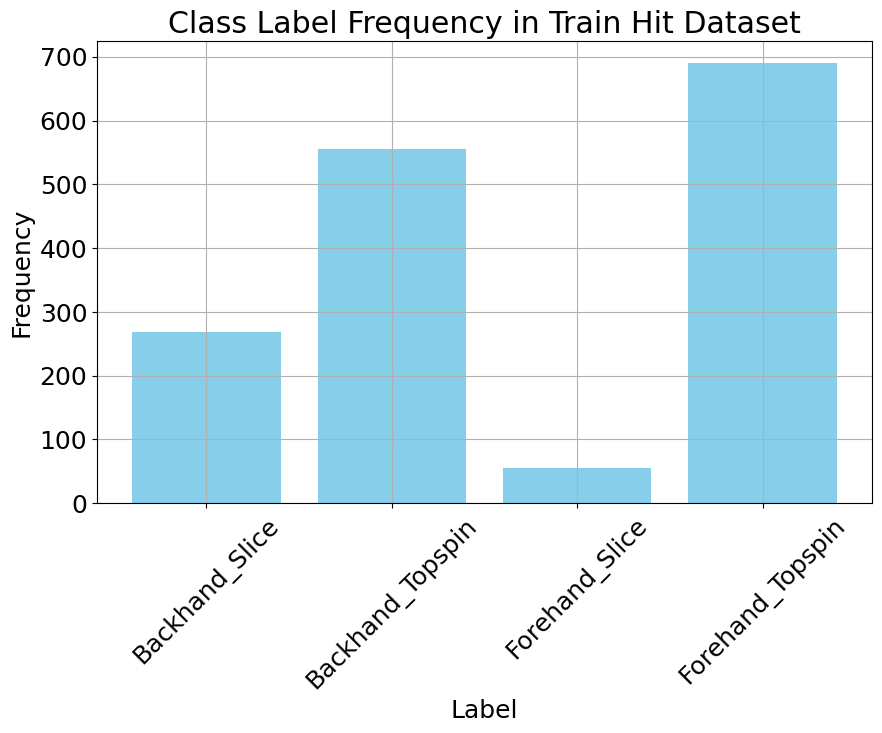

In [54]:
get_data_info(train_hit_dataset, "Train Hit Dataset", task="hit", keep_labels=hit_labels_keep)

Val Hit Dataset:
Pose3d Shape:  (19, 17, 3)
Position2d Shape:  (19, 2)
Number of PoseGraphs:  19
Number of Samples:  374
Number of Unique Labels:  4
Unique Labels and their counts:
Label Backhand_Slice: 64
Label Backhand_Topspin: 130
Label Forehand_Slice: 10
Label Forehand_Topspin: 170


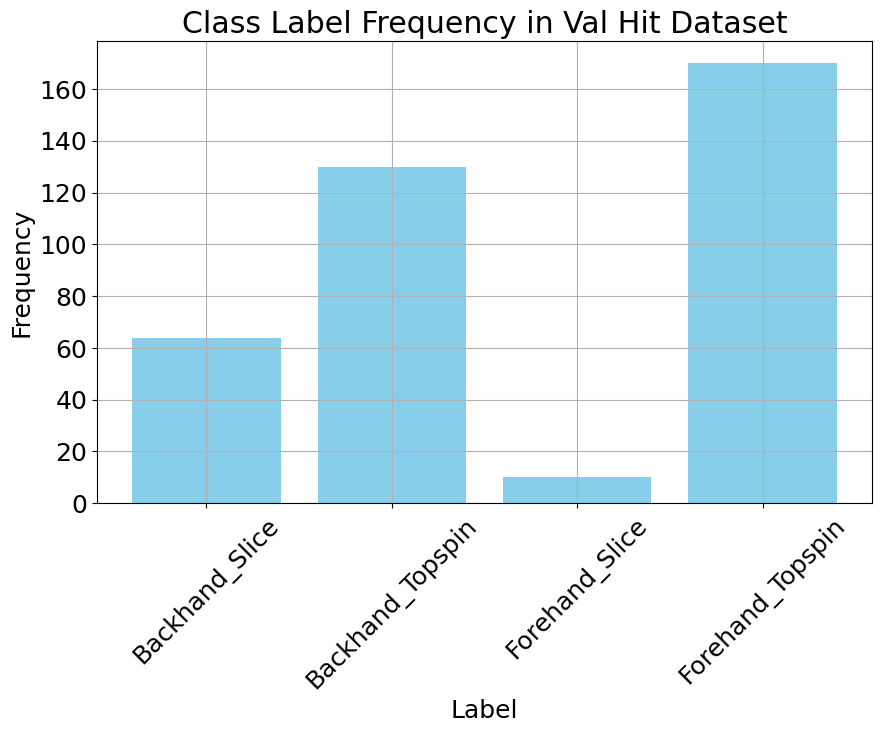

In [55]:
get_data_info(val_hit_dataset, "Val Hit Dataset", task="hit", keep_labels=hit_labels_keep)

Test Hit Dataset:
Pose3d Shape:  (21, 17, 3)
Position2d Shape:  (21, 2)
Number of PoseGraphs:  21
Number of Samples:  263
Number of Unique Labels:  4
Unique Labels and their counts:
Label Backhand_Slice: 14
Label Backhand_Topspin: 117
Label Forehand_Slice: 5
Label Forehand_Topspin: 127


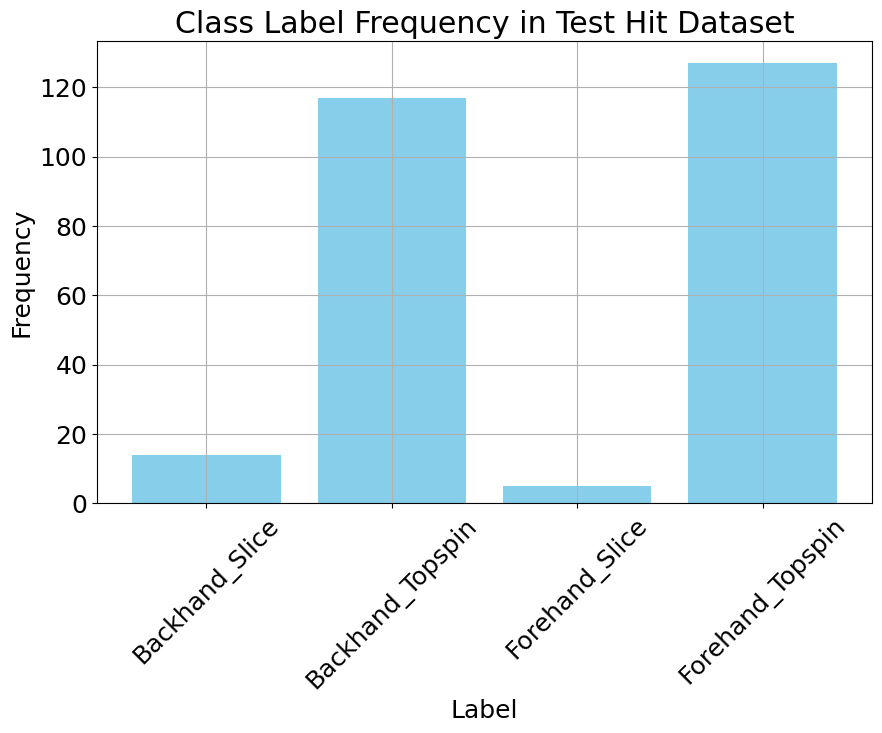

In [56]:
get_data_info(test_hit_dataset, "Test Hit Dataset", task="hit", keep_labels=hit_labels_keep)

### 1) Freeze Base Model and only train classification head on top 4 classes for Hit

In [83]:
hit_labels_keep = ["Forehand_Topspin", "Backhand_Topspin", "Backhand_Slice", "Forehand_Slice"]

In [99]:
# Configure the DownstreamClassifierTaskTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50

In [103]:
hit_downstream_model = DownstreamClassificationTaskTrainer(model_config_path=model_config_file,
                                                             model_weights_path=model_weights_path, 
                                                             train_path=train_path, 
                                                             val_path=val_path, 
                                                             test_path=test_path, 
                                                             model_save_path='downstream_trained_models', 
                                                             batch_size=BATCH_SIZE, 
                                                             lr=LR, 
                                                             epochs=EPOCHS, 
                                                             task = 'hit', 
                                                             keep_labels=hit_labels_keep, 
                                                             freeze_feature_extractor=True)

Using device: cuda


100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


Epoch 1, Loss: 1.0974904644489287
Validation Accuracy: 0.4625668449197861, Validation Precision: 0.4375067995614806, Validation Recall: 0.4625668449197861, Validation F1 Score: 0.3977220562898312
Saving model at hit_downstream_trained_models with validation loss of 1.0611212799946468


100%|██████████| 50/50 [00:07<00:00,  7.05it/s]


Epoch 2, Loss: 1.0717276418209076
Validation Accuracy: 0.5347593582887701, Validation Precision: 0.5732406269490669, Validation Recall: 0.5347593582887701, Validation F1 Score: 0.5088032594072961
Saving model at hit_downstream_trained_models with validation loss of 1.006883904337883


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Epoch 3, Loss: 1.0401744425296784
Validation Accuracy: 0.5454545454545454, Validation Precision: 0.5490479019890785, Validation Recall: 0.5454545454545454, Validation F1 Score: 0.4950201313837677


100%|██████████| 50/50 [00:07<00:00,  6.76it/s]


Epoch 4, Loss: 1.034578528404236
Validation Accuracy: 0.5374331550802139, Validation Precision: 0.5760421602295112, Validation Recall: 0.5374331550802139, Validation F1 Score: 0.5142981279650206
Saving model at hit_downstream_trained_models with validation loss of 0.9849528471628824


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch 5, Loss: 1.0099678814411164
Validation Accuracy: 0.5828877005347594, Validation Precision: 0.5616354119814327, Validation Recall: 0.5828877005347594, Validation F1 Score: 0.5471918234542317
Saving model at hit_downstream_trained_models with validation loss of 0.9760259141524633


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


Epoch 6, Loss: 1.0150788056850433
Validation Accuracy: 0.5828877005347594, Validation Precision: 0.557312398643668, Validation Recall: 0.5828877005347594, Validation F1 Score: 0.5663662131971066
Saving model at hit_downstream_trained_models with validation loss of 0.9688719908396403


100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


Epoch 7, Loss: 0.9977852153778076
Validation Accuracy: 0.5481283422459893, Validation Precision: 0.5870193187840246, Validation Recall: 0.5481283422459893, Validation F1 Score: 0.5332981393662986


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Epoch 8, Loss: 1.0123431420326232
Validation Accuracy: 0.553475935828877, Validation Precision: 0.5643370295776714, Validation Recall: 0.553475935828877, Validation F1 Score: 0.5426511235240374


100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Epoch 9, Loss: 0.9952607929706574
Validation Accuracy: 0.5641711229946524, Validation Precision: 0.5602400684170461, Validation Recall: 0.5641711229946524, Validation F1 Score: 0.553412497276769
Saving model at hit_downstream_trained_models with validation loss of 0.9607728272676468


100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Epoch 10, Loss: 0.9959344387054443
Validation Accuracy: 0.5802139037433155, Validation Precision: 0.5752401903297044, Validation Recall: 0.5802139037433155, Validation F1 Score: 0.5686744824955173
Saving model at hit_downstream_trained_models with validation loss of 0.9591825505097707


100%|██████████| 50/50 [00:07<00:00,  6.85it/s]


Epoch 11, Loss: 0.9887287664413452
Validation Accuracy: 0.5855614973262032, Validation Precision: 0.585204991087344, Validation Recall: 0.5855614973262032, Validation F1 Score: 0.5703377116285787
Saving model at hit_downstream_trained_models with validation loss of 0.9576882421970367


100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Epoch 12, Loss: 0.9866658675670624
Validation Accuracy: 0.5561497326203209, Validation Precision: 0.5316346307909533, Validation Recall: 0.5561497326203209, Validation F1 Score: 0.5381888565611834


100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


Epoch 13, Loss: 0.9913061439990998
Validation Accuracy: 0.5828877005347594, Validation Precision: 0.6090725092534285, Validation Recall: 0.5828877005347594, Validation F1 Score: 0.5718833126871165
Saving model at hit_downstream_trained_models with validation loss of 0.9525357335805893


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 14, Loss: 0.9813514411449432
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.6040969983651534, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.5714959384635749


100%|██████████| 50/50 [00:07<00:00,  6.80it/s]


Epoch 15, Loss: 0.9863564908504486
Validation Accuracy: 0.5401069518716578, Validation Precision: 0.5752985647291593, Validation Recall: 0.5401069518716578, Validation F1 Score: 0.524844775379358


100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 16, Loss: 0.9682245150208473
Validation Accuracy: 0.553475935828877, Validation Precision: 0.597274751213755, Validation Recall: 0.553475935828877, Validation F1 Score: 0.5376030016811231


100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


Epoch 17, Loss: 0.9635982096195221
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.5785169144316467, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.5773982972795414
Saving model at hit_downstream_trained_models with validation loss of 0.944097692767779


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Epoch 18, Loss: 0.9745374763011933
Validation Accuracy: 0.5721925133689839, Validation Precision: 0.5935095169628988, Validation Recall: 0.5721925133689839, Validation F1 Score: 0.5618011667476909


100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


Epoch 19, Loss: 0.9610239040851593
Validation Accuracy: 0.6042780748663101, Validation Precision: 0.6149839902290883, Validation Recall: 0.6042780748663101, Validation F1 Score: 0.5813379231136253
Saving model at hit_downstream_trained_models with validation loss of 0.9431642492612203


100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


Epoch 20, Loss: 0.9685459125041962
Validation Accuracy: 0.5909090909090909, Validation Precision: 0.6086306071414039, Validation Recall: 0.5909090909090909, Validation F1 Score: 0.5764381331473617


100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 21, Loss: 0.9641945552825928
Validation Accuracy: 0.5775401069518716, Validation Precision: 0.5879832497179466, Validation Recall: 0.5775401069518716, Validation F1 Score: 0.5634783651821818
Saving model at hit_downstream_trained_models with validation loss of 0.9394741803407669


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Epoch 22, Loss: 0.9560057723522186
Validation Accuracy: 0.5614973262032086, Validation Precision: 0.6290684912313476, Validation Recall: 0.5614973262032086, Validation F1 Score: 0.5460686517182767


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


Epoch 23, Loss: 0.954809365272522
Validation Accuracy: 0.5909090909090909, Validation Precision: 0.6051351459720001, Validation Recall: 0.5909090909090909, Validation F1 Score: 0.5750262509314531
Saving model at hit_downstream_trained_models with validation loss of 0.9387131532033285


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Epoch 24, Loss: 0.9651491963863372
Validation Accuracy: 0.5668449197860963, Validation Precision: 0.5873758273535359, Validation Recall: 0.5668449197860963, Validation F1 Score: 0.5566833987858036


100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Epoch 25, Loss: 0.9589527297019959
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.6119056643904514, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.5734450050673355


100%|██████████| 50/50 [00:07<00:00,  6.77it/s]


Epoch 26, Loss: 0.9368827223777771
Validation Accuracy: 0.5989304812834224, Validation Precision: 0.5963597348635168, Validation Recall: 0.5989304812834224, Validation F1 Score: 0.589332193257986


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Epoch 27, Loss: 0.93159308552742
Validation Accuracy: 0.5935828877005348, Validation Precision: 0.5854325778726606, Validation Recall: 0.5935828877005348, Validation F1 Score: 0.5772432008412518
Saving model at hit_downstream_trained_models with validation loss of 0.9357116371393204


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Epoch 28, Loss: 0.9456272768974304
Validation Accuracy: 0.5828877005347594, Validation Precision: 0.5746334285954637, Validation Recall: 0.5828877005347594, Validation F1 Score: 0.5721549118440619


100%|██████████| 50/50 [00:07<00:00,  6.93it/s]


Epoch 29, Loss: 0.9686872637271882
Validation Accuracy: 0.5989304812834224, Validation Precision: 0.6066696119849911, Validation Recall: 0.5989304812834224, Validation F1 Score: 0.5768746839681096


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 30, Loss: 0.9371954476833344
Validation Accuracy: 0.56951871657754, Validation Precision: 0.5803909539664794, Validation Recall: 0.56951871657754, Validation F1 Score: 0.56103172302615


100%|██████████| 50/50 [00:07<00:00,  6.56it/s]


Epoch 31, Loss: 0.9290307247638703
Validation Accuracy: 0.56951871657754, Validation Precision: 0.628418640183346, Validation Recall: 0.56951871657754, Validation F1 Score: 0.5570016436326597


100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


Epoch 32, Loss: 0.9367230868339539
Validation Accuracy: 0.5748663101604278, Validation Precision: 0.5838075455201575, Validation Recall: 0.5748663101604278, Validation F1 Score: 0.5656705832251117


100%|██████████| 50/50 [00:07<00:00,  6.95it/s]


Epoch 33, Loss: 0.9354390633106232
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.5777616990852285, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.5760243288355303


100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


Epoch 34, Loss: 0.9047819882631302
Validation Accuracy: 0.6016042780748663, Validation Precision: 0.6003919444267414, Validation Recall: 0.6016042780748663, Validation F1 Score: 0.5791528165309229


100%|██████████| 50/50 [00:07<00:00,  6.78it/s]


Epoch 35, Loss: 0.9428216409683228
Validation Accuracy: 0.5748663101604278, Validation Precision: 0.5694042199870394, Validation Recall: 0.5748663101604278, Validation F1 Score: 0.5677210019892273


100%|██████████| 50/50 [00:07<00:00,  6.90it/s]


Epoch 36, Loss: 0.9419339323043823
Validation Accuracy: 0.5775401069518716, Validation Precision: 0.5691963474540794, Validation Recall: 0.5775401069518716, Validation F1 Score: 0.5657767905917115


100%|██████████| 50/50 [00:07<00:00,  6.58it/s]


Epoch 37, Loss: 0.9316112196445465
Validation Accuracy: 0.6096256684491979, Validation Precision: 0.6163577253793652, Validation Recall: 0.6096256684491979, Validation F1 Score: 0.5917808246387556
Saving model at hit_downstream_trained_models with validation loss of 0.9283391733964285


100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


Epoch 38, Loss: 0.9038109624385834
Validation Accuracy: 0.5775401069518716, Validation Precision: 0.6088171052106917, Validation Recall: 0.5775401069518716, Validation F1 Score: 0.5663971807783927


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch 39, Loss: 0.9177376580238342
Validation Accuracy: 0.5775401069518716, Validation Precision: 0.5570012769750373, Validation Recall: 0.5775401069518716, Validation F1 Score: 0.5635580629407241


100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Epoch 40, Loss: 0.9052640068531036
Validation Accuracy: 0.5989304812834224, Validation Precision: 0.5969394387857759, Validation Recall: 0.5989304812834224, Validation F1 Score: 0.5690415973079163


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 41, Loss: 0.8972558134794235
Validation Accuracy: 0.6016042780748663, Validation Precision: 0.5965602982749415, Validation Recall: 0.6016042780748663, Validation F1 Score: 0.5790735795101404


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Epoch 42, Loss: 0.8969856214523315
Validation Accuracy: 0.5962566844919787, Validation Precision: 0.5965481463476117, Validation Recall: 0.5962566844919787, Validation F1 Score: 0.5848545824274344


100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


Epoch 43, Loss: 0.8778223168849945
Validation Accuracy: 0.5641711229946524, Validation Precision: 0.6068421310685376, Validation Recall: 0.5641711229946524, Validation F1 Score: 0.5492949666287931


100%|██████████| 50/50 [00:07<00:00,  6.68it/s]


Epoch 44, Loss: 0.8864020341634751
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.5644925935476279, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.5742655401616262


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch 45, Loss: 0.9055545938014984
Validation Accuracy: 0.5748663101604278, Validation Precision: 0.5842773658113486, Validation Recall: 0.5748663101604278, Validation F1 Score: 0.5678517157681723


100%|██████████| 50/50 [00:07<00:00,  6.71it/s]


Epoch 46, Loss: 0.8954473292827606
Validation Accuracy: 0.5989304812834224, Validation Precision: 0.5791137008162949, Validation Recall: 0.5989304812834224, Validation F1 Score: 0.5829831327679598


100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch 47, Loss: 0.9045038819313049
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.567050469589556, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.573353524835319


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Epoch 48, Loss: 0.8998168194293976
Validation Accuracy: 0.5614973262032086, Validation Precision: 0.5994434937636158, Validation Recall: 0.5614973262032086, Validation F1 Score: 0.5440124144089399


100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Epoch 49, Loss: 0.976201286315918
Validation Accuracy: 0.5775401069518716, Validation Precision: 0.5989576522892421, Validation Recall: 0.5775401069518716, Validation F1 Score: 0.5667035169462888


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch 50, Loss: 0.9086018145084381
Validation Accuracy: 0.5668449197860963, Validation Precision: 0.5934068610057038, Validation Recall: 0.5668449197860963, Validation F1 Score: 0.5650750287602291
Test Accuracy: 0.6387832699619772, Test Precision: 0.6386212010894479, Test Recall: 0.6387832699619772, Test F1 Score: 0.6353085983235859


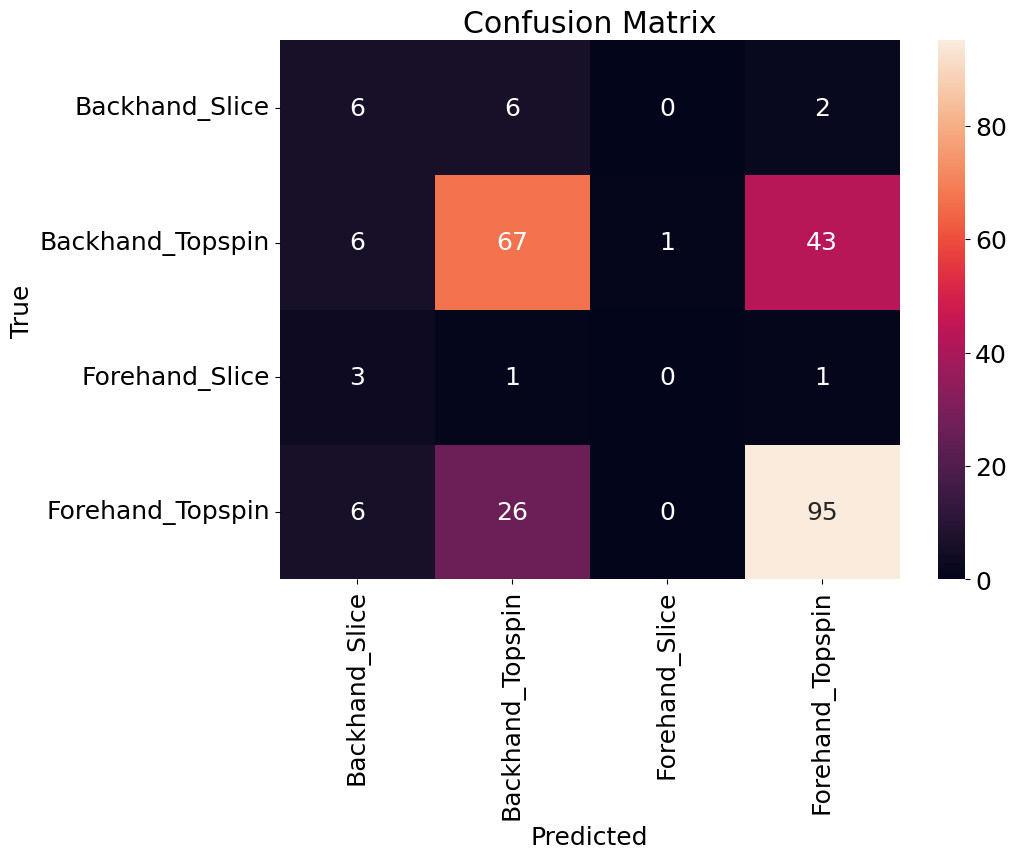

In [105]:
train_loss_history = hit_downstream_model.train()

### 2) Train the complete model on top 4 classes for Hit


In [109]:
# Configure the DownstreamClassifierTaskTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50
hit_model_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth"

In [110]:
hit_downstream_model = DownstreamClassificationTaskTrainer(model_config_path=model_config_file,
                                                             model_weights_path=model_weights_path, 
                                                             train_path=train_path, 
                                                             val_path=val_path, 
                                                             test_path=test_path, 
                                                             model_save_path='downstream_trained_models', 
                                                             batch_size=BATCH_SIZE, 
                                                             lr=LR, 
                                                             epochs=EPOCHS, 
                                                             task = 'hit', 
                                                             keep_labels=hit_labels_keep, 
                                                             freeze_feature_extractor=False)

Using device: cuda


In [111]:
hit_downstream_model.load_model(hit_model_path)

Model loaded from /home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch 1, Loss: 1.0290635180473329
Validation Accuracy: 0.5614973262032086, Validation Precision: 0.5542059918949016, Validation Recall: 0.5614973262032086, Validation F1 Score: 0.5473972156810241
Saving model at hit_downstream_trained_models with validation loss of 1.0333094497521718


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Epoch 2, Loss: 1.0326947116851806
Validation Accuracy: 0.5989304812834224, Validation Precision: 0.5929713493806624, Validation Recall: 0.5989304812834224, Validation F1 Score: 0.5663136830902035
Saving model at hit_downstream_trained_models with validation loss of 0.9697285195191702


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Epoch 3, Loss: 0.9881125903129577
Validation Accuracy: 0.6149732620320856, Validation Precision: 0.6069708880030427, Validation Recall: 0.6149732620320856, Validation F1 Score: 0.6005327031998571
Saving model at hit_downstream_trained_models with validation loss of 0.9360202848911285


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


Epoch 4, Loss: 0.9590093433856964
Validation Accuracy: 0.5935828877005348, Validation Precision: 0.6072520378709859, Validation Recall: 0.5935828877005348, Validation F1 Score: 0.5786706550891458


100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


Epoch 5, Loss: 1.0035142982006073
Validation Accuracy: 0.5882352941176471, Validation Precision: 0.574173930963065, Validation Recall: 0.5882352941176471, Validation F1 Score: 0.5403094941043622


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


Epoch 6, Loss: 0.9007582819461822
Validation Accuracy: 0.6470588235294118, Validation Precision: 0.6570338208993671, Validation Recall: 0.6470588235294118, Validation F1 Score: 0.629752515264284
Saving model at hit_downstream_trained_models with validation loss of 0.880467469493548


100%|██████████| 50/50 [00:09<00:00,  5.16it/s]


Epoch 7, Loss: 0.8785113632678986
Validation Accuracy: 0.5614973262032086, Validation Precision: 0.5596469266777842, Validation Recall: 0.5614973262032086, Validation F1 Score: 0.5359475629763593


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Epoch 8, Loss: 0.8904717993736267
Validation Accuracy: 0.6149732620320856, Validation Precision: 0.6006388320793852, Validation Recall: 0.6149732620320856, Validation F1 Score: 0.6006588436539803


100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch 9, Loss: 0.8569405817985535
Validation Accuracy: 0.6229946524064172, Validation Precision: 0.600420442866486, Validation Recall: 0.6229946524064172, Validation F1 Score: 0.5939965782520551
Saving model at hit_downstream_trained_models with validation loss of 0.866667240858078


100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


Epoch 10, Loss: 0.8444426941871643
Validation Accuracy: 0.6631016042780749, Validation Precision: 0.6801509800231028, Validation Recall: 0.6631016042780749, Validation F1 Score: 0.6468914531189685
Saving model at hit_downstream_trained_models with validation loss of 0.8266882250706354


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Epoch 11, Loss: 0.8011996400356293
Validation Accuracy: 0.6390374331550802, Validation Precision: 0.655122701812665, Validation Recall: 0.6390374331550802, Validation F1 Score: 0.5947935160036661


100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


Epoch 12, Loss: 0.8273851788043975
Validation Accuracy: 0.7058823529411765, Validation Precision: 0.7395431970158773, Validation Recall: 0.7058823529411765, Validation F1 Score: 0.6899394680738576
Saving model at hit_downstream_trained_models with validation loss of 0.7864408592383066


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Epoch 13, Loss: 0.8230376172065735
Validation Accuracy: 0.6978609625668449, Validation Precision: 0.7143414160393884, Validation Recall: 0.6978609625668449, Validation F1 Score: 0.6705559423848415
Saving model at hit_downstream_trained_models with validation loss of 0.7468226750691732


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


Epoch 14, Loss: 0.8085729205608367
Validation Accuracy: 0.6898395721925134, Validation Precision: 0.7325195690924593, Validation Recall: 0.6898395721925134, Validation F1 Score: 0.6592251885490565


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Epoch 15, Loss: 0.8152969980239868
Validation Accuracy: 0.6443850267379679, Validation Precision: 0.7173097001792733, Validation Recall: 0.6443850267379679, Validation F1 Score: 0.6239962881514869


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Epoch 16, Loss: 0.8130172181129456
Validation Accuracy: 0.6898395721925134, Validation Precision: 0.7000463568483966, Validation Recall: 0.6898395721925134, Validation F1 Score: 0.675569093250895


100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Epoch 17, Loss: 0.8200197529792785
Validation Accuracy: 0.7112299465240641, Validation Precision: 0.7433591160771688, Validation Recall: 0.7112299465240641, Validation F1 Score: 0.6958459320207915


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Epoch 18, Loss: 0.7924865531921387
Validation Accuracy: 0.6898395721925134, Validation Precision: 0.72030721576248, Validation Recall: 0.6898395721925134, Validation F1 Score: 0.6617521072383853


100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


Epoch 19, Loss: 0.7962143540382385
Validation Accuracy: 0.7005347593582888, Validation Precision: 0.7214453208912328, Validation Recall: 0.7005347593582888, Validation F1 Score: 0.6757088288614217


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


Epoch 20, Loss: 0.7616920417547226
Validation Accuracy: 0.7299465240641712, Validation Precision: 0.7487776706273083, Validation Recall: 0.7299465240641712, Validation F1 Score: 0.7128101765657435


100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


Epoch 21, Loss: 0.7523930877447128
Validation Accuracy: 0.7085561497326203, Validation Precision: 0.7359066106572849, Validation Recall: 0.7085561497326203, Validation F1 Score: 0.6854801578484678
Saving model at hit_downstream_trained_models with validation loss of 0.7305403848489126


100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


Epoch 22, Loss: 0.7176926273107529
Validation Accuracy: 0.713903743315508, Validation Precision: 0.7359289675466146, Validation Recall: 0.713903743315508, Validation F1 Score: 0.6918242622682318


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Epoch 23, Loss: 0.7409968763589859
Validation Accuracy: 0.6149732620320856, Validation Precision: 0.6748870074819519, Validation Recall: 0.6149732620320856, Validation F1 Score: 0.5981842089994474


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch 24, Loss: 0.8367043733596802
Validation Accuracy: 0.679144385026738, Validation Precision: 0.6688934074734298, Validation Recall: 0.679144385026738, Validation F1 Score: 0.6587101857018408


100%|██████████| 50/50 [00:09<00:00,  5.41it/s]


Epoch 25, Loss: 0.7944228821992874
Validation Accuracy: 0.6737967914438503, Validation Precision: 0.674032116729223, Validation Recall: 0.6737967914438503, Validation F1 Score: 0.6312332610302545


100%|██████████| 50/50 [00:09<00:00,  5.00it/s]


Epoch 26, Loss: 0.7257890996336936
Validation Accuracy: 0.7032085561497327, Validation Precision: 0.7315193332701209, Validation Recall: 0.7032085561497327, Validation F1 Score: 0.6872021213597542


100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch 27, Loss: 0.7191585475206375
Validation Accuracy: 0.7085561497326203, Validation Precision: 0.7462295123096843, Validation Recall: 0.7085561497326203, Validation F1 Score: 0.6845376435387496


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch 28, Loss: 0.7125038582086564
Validation Accuracy: 0.6925133689839572, Validation Precision: 0.7513800578931478, Validation Recall: 0.6925133689839572, Validation F1 Score: 0.6752567763365684


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Epoch 29, Loss: 0.7029052650928498
Validation Accuracy: 0.6925133689839572, Validation Precision: 0.7028452178121113, Validation Recall: 0.6925133689839572, Validation F1 Score: 0.6809971568057438


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


Epoch 30, Loss: 0.6988535398244857
Validation Accuracy: 0.7112299465240641, Validation Precision: 0.7578033183719893, Validation Recall: 0.7112299465240641, Validation F1 Score: 0.691248869791426


100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


Epoch 31, Loss: 0.7377740579843521
Validation Accuracy: 0.713903743315508, Validation Precision: 0.7311163362513411, Validation Recall: 0.713903743315508, Validation F1 Score: 0.6887590361055441


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch 32, Loss: 0.7802279835939407
Validation Accuracy: 0.7058823529411765, Validation Precision: 0.7347124848723314, Validation Recall: 0.7058823529411765, Validation F1 Score: 0.6864203488936953


100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


Epoch 33, Loss: 0.7121980977058411
Validation Accuracy: 0.6844919786096256, Validation Precision: 0.6685973446481324, Validation Recall: 0.6844919786096256, Validation F1 Score: 0.6677963403562306


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch 34, Loss: 0.7872044593095779
Validation Accuracy: 0.6336898395721925, Validation Precision: 0.6634515226852069, Validation Recall: 0.6336898395721925, Validation F1 Score: 0.6254137480477487


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Epoch 35, Loss: 0.7881899654865265
Validation Accuracy: 0.7032085561497327, Validation Precision: 0.7152099330408154, Validation Recall: 0.7032085561497327, Validation F1 Score: 0.6829291107928879


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


Epoch 36, Loss: 0.6748536694049835
Validation Accuracy: 0.6871657754010695, Validation Precision: 0.7000255189260401, Validation Recall: 0.6871657754010695, Validation F1 Score: 0.679992606990857


100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


Epoch 37, Loss: 0.6575921994447708
Validation Accuracy: 0.7165775401069518, Validation Precision: 0.7137333430922722, Validation Recall: 0.7165775401069518, Validation F1 Score: 0.7017206545301979
Saving model at hit_downstream_trained_models with validation loss of 0.725077490011851


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Epoch 38, Loss: 0.6625738781690598
Validation Accuracy: 0.7192513368983957, Validation Precision: 0.7507431776881492, Validation Recall: 0.7192513368983957, Validation F1 Score: 0.7040836524260586


100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


Epoch 39, Loss: 0.6805511337518692
Validation Accuracy: 0.7112299465240641, Validation Precision: 0.7035832522911747, Validation Recall: 0.7112299465240641, Validation F1 Score: 0.7001278698341018


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


Epoch 40, Loss: 0.6589235833287239
Validation Accuracy: 0.6871657754010695, Validation Precision: 0.6975874999890421, Validation Recall: 0.6871657754010695, Validation F1 Score: 0.6906430302533016


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Epoch 41, Loss: 0.6512152183055878
Validation Accuracy: 0.679144385026738, Validation Precision: 0.7367218634398403, Validation Recall: 0.679144385026738, Validation F1 Score: 0.6695940361141252


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Epoch 42, Loss: 0.7175054562091827
Validation Accuracy: 0.6871657754010695, Validation Precision: 0.7083210394064932, Validation Recall: 0.6871657754010695, Validation F1 Score: 0.6867480361852215


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Epoch 43, Loss: 0.629217473268509
Validation Accuracy: 0.7245989304812834, Validation Precision: 0.7260625496923079, Validation Recall: 0.7245989304812834, Validation F1 Score: 0.7079573337657831
Saving model at hit_downstream_trained_models with validation loss of 0.7079383879899979


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Epoch 44, Loss: 0.6281560724973678
Validation Accuracy: 0.7085561497326203, Validation Precision: 0.7137135846073968, Validation Recall: 0.7085561497326203, Validation F1 Score: 0.7046761756287309


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Epoch 45, Loss: 0.6128672009706497
Validation Accuracy: 0.6818181818181818, Validation Precision: 0.7095391539902746, Validation Recall: 0.6818181818181818, Validation F1 Score: 0.6764613112454722


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


Epoch 46, Loss: 0.6414609599113464
Validation Accuracy: 0.6577540106951871, Validation Precision: 0.688151224232223, Validation Recall: 0.6577540106951871, Validation F1 Score: 0.6592632360348896


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


Epoch 47, Loss: 0.7183219248056412
Validation Accuracy: 0.7005347593582888, Validation Precision: 0.749647845104819, Validation Recall: 0.7005347593582888, Validation F1 Score: 0.6890762289699001


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch 48, Loss: 0.6981910020112991
Validation Accuracy: 0.7352941176470589, Validation Precision: 0.7610241766251997, Validation Recall: 0.7352941176470589, Validation F1 Score: 0.7181852032216347


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Epoch 49, Loss: 0.6672348010540009
Validation Accuracy: 0.7058823529411765, Validation Precision: 0.720568887961557, Validation Recall: 0.7058823529411765, Validation F1 Score: 0.7069684361424354


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Epoch 50, Loss: 0.6202317678928375
Validation Accuracy: 0.7112299465240641, Validation Precision: 0.7253155600831251, Validation Recall: 0.7112299465240641, Validation F1 Score: 0.7110987790175164
Test Accuracy: 0.7604562737642585, Test Precision: 0.7626029503351098, Test Recall: 0.7604562737642585, Test F1 Score: 0.7601327376573163


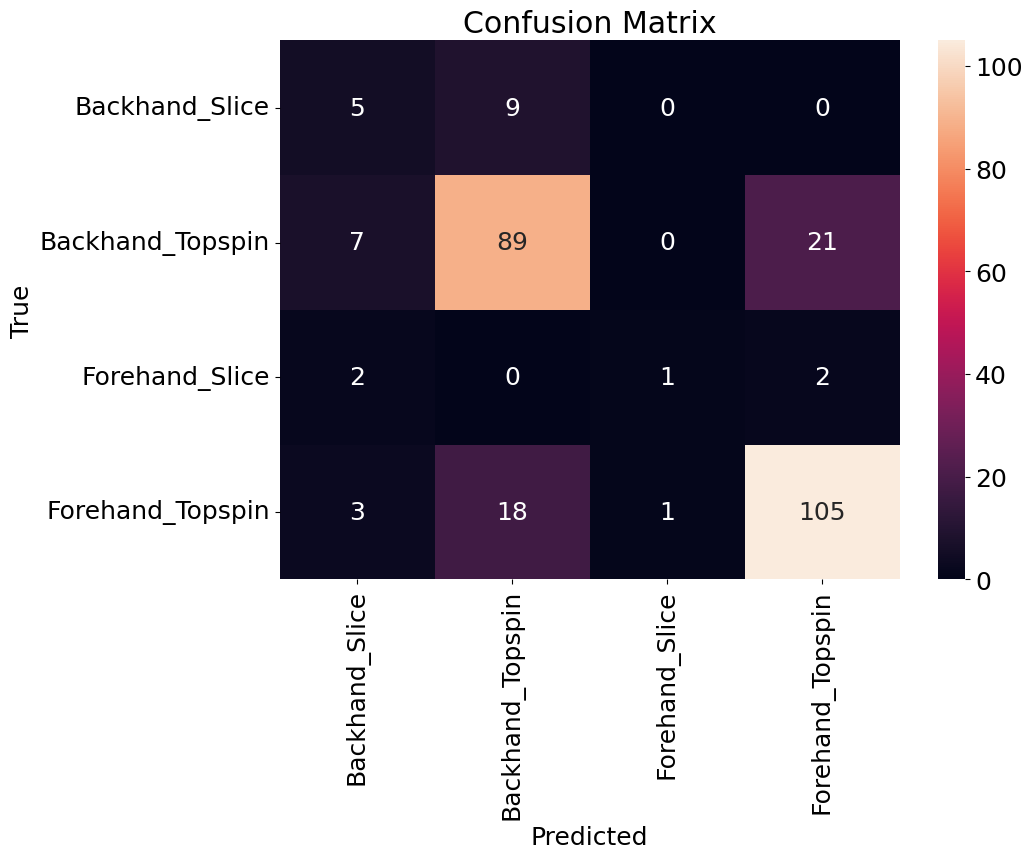

array([1.02906352, 1.03269471, 0.98811259, 0.95900934, 1.0035143 ,
       0.90075828, 0.87851136, 0.8904718 , 0.85694058, 0.84444269,
       0.80119964, 0.82738518, 0.82303762, 0.80857292, 0.815297  ,
       0.81301722, 0.82001975, 0.79248655, 0.79621435, 0.76169204,
       0.75239309, 0.71769263, 0.74099688, 0.83670437, 0.79442288,
       0.7257891 , 0.71915855, 0.71250386, 0.70290527, 0.69885354,
       0.73777406, 0.78022798, 0.7121981 , 0.78720446, 0.78818997,
       0.67485367, 0.6575922 , 0.66257388, 0.68055113, 0.65892358,
       0.65121522, 0.71750546, 0.62921747, 0.62815607, 0.6128672 ,
       0.64146096, 0.71832192, 0.698191  , 0.6672348 , 0.62023177])

In [112]:
training_loss = hit_downstream_model.train()

In [113]:
hit_model_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth"
hit_downstream_model.load_model(hit_model_path)

Model loaded from /home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth
